## Other maturities

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 

from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.optimize import minimize
import scipy.integrate as integrate
from scipy import special
from scipy.special import erf
from scipy import optimize
from datetime import date
from datetime import datetime

In [54]:
# Preprocessing
amd_quotes = pd.read_csv('amd_quotedata.csv', parse_dates=['Expiration Date'], index_col=['Expiration Date'])
amd_calls = amd_quotes.iloc[:,0:11] # Remove puts
#amd_calls = amd_calls1.drop('2023-04-06', inplace=True) # Remove date before start date

S0 = 92.3
t0 = date(2023, 4, 8)
amd_calls['Strike/Spot'] = amd_calls['Strike']/S0
amd_calls['Mid'] = (amd_calls['Bid']+amd_calls['Ask'])/2
amd_calls

,Calls,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,Open Interest,Strike,Strike/Spot,Mid
Expiration Date,,,,,,,,,,,,,
2023-04-06,AMD230406C00083000,9.50,0.000,9.35,9.55,126,0.0000,0.9984,0.0015,144,83.0,0.899242,9.450
2023-04-06,AMD230406C00084000,8.70,0.275,8.35,8.55,35,0.0000,0.9982,0.0019,110,84.0,0.910076,8.450
2023-04-06,AMD230406C00085000,7.55,0.150,7.35,7.55,180,0.0000,0.9979,0.0024,907,85.0,0.920910,7.450
2023-04-06,AMD230406C00086000,6.63,0.205,6.35,6.55,60,0.0000,0.9976,0.0031,296,86.0,0.931744,6.450
2023-04-06,AMD230406C00087000,5.61,0.110,5.35,5.60,320,0.0000,0.9972,0.0042,308,87.0,0.942579,5.475
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-19,AMD251219C00120000,21.43,-0.220,20.95,22.30,23,0.4378,0.5719,0.0060,70,120.0,1.300108,21.625
2025-12-19,AMD251219C00125000,19.20,-1.000,19.85,20.80,5,0.4371,0.5475,0.0061,27,125.0,1.354280,20.325
2025-12-19,AMD251219C00130000,17.55,-1.225,18.50,19.45,10,0.4342,0.5238,0.0061,33,130.0,1.408451,18.975


In [55]:
def iv(p,K,T,r,S0):
    """
    Calculate implied volatility using Black-Scholes formula
    
    Parameters:
    p (float): Market price(s) of the option
    K (float): Strike price(s) of the option
    T (float): Time to expiry of the option, in years
    r (float): Risk-free interest rate, as a decimal
    S0 (float): Current price of the underlying asset
    """
    
    d1 = lambda sigma: (np.log(S0/K) + (r + 0.5*(sigma**2))*T) / (sigma*np.sqrt(T))
    d2 = lambda sigma: d1(sigma) - sigma*np.sqrt(T)
    option_price = lambda sigma: S0*norm.cdf(d1(sigma)) - K*np.exp(-r*T)*norm.cdf(d2(sigma))
    option_price_diff = lambda sigma: option_price(sigma) - p
    
    return fsolve(option_price_diff, 0.2*np.ones(len(p)))

In [56]:
def I1(alpha,sigma,s1,K1,K2): 
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return 1/2*np.exp((alpha*sigma)**2/2 + alpha*s1) * (special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2)) )
    
def I2(alpha,sigma,s1,K1,K2):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return sigma*np.exp(alpha*s1) * ( 2*(np.exp(A*alpha*sigma-A*A/2) - np.exp(B*alpha*sigma-B*B/2)) + np.sqrt(2*np.pi)*alpha*sigma*np.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2))) )
    
def I3(alpha,sigma,s1,K1,K2,Q):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return np.exp(alpha*s1) *  (2*sigma*(np.exp(A*alpha*sigma-A**2/2) - np.exp(B*alpha*sigma-B**2/2))  +   np.sqrt(2*np.pi)*np.exp(alpha*alpha*sigma*sigma/2)*(alpha*sigma**2-Q+s1) * (erf((B-alpha*sigma)/np.sqrt(2)) - erf((A-alpha*sigma)/np.sqrt(2))) )

def I4(alpha,sigma,s1,K1,K2,K,Q):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma  
    return 2*sigma* (np.exp(alpha*A*sigma-A*A/2)*(sigma*(alpha*sigma+A) - K - Q + 2*s1) + np.exp(-1/2*B*(B-2*alpha*sigma))*(-sigma*(alpha*sigma+B) + K + Q -2*s1))  +  np.sqrt(2*np.pi)*np.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/(np.sqrt(2))) - special.erf((A-alpha*sigma)/(np.sqrt(2))) ) * (sigma**2 - (-alpha*sigma**2+K-s1)*(alpha*sigma**2-Q+s1))

In [57]:
SQRT2 = np.sqrt(2)
INV_SQRT2_PI = 1. / np.sqrt(2 * math.pi)
def sigma_objective_(p,C,delta_t,X1,P_disc_X1):
    '''
    C: Pandas dataframe containing all info of that volatility slice (fixed maturity)
    '''
    mid = np.array(C['Mid'])
    K = np.array(C['Strike'])
    sigma0, beta = p[0], p[1]
    sqrtt = math.sqrt(delta_t)
    sigma = lambda s: sigma0*s**beta
    tot = 0
    
    for i in range(K.size): 
        k = K[i]
        help_v = lambda s: (k-s)/(np.sqrt(2)*sqrtt*sigma(s))
        B_vec = lambda s: 0.5*(s-k)*erf(help_v(s)) + sigma(s)*sqrtt/np.sqrt(2*math.pi)*np.exp(-help_v(s)**2)
        B_vec_ = np.vectorize(B_vec)
        expectation_k = np.sum(B_vec_(X1)*P_disc_X1)
        tot += (expectation_k - mid[i])**2 #TODO: compare these two, to check for good fit
        
    #print(f'tot = {tot}')
    return tot


def calculate_sigma0_beta(C,delta_t,X1,P_disc_X1):
    res = optimize.minimize(sigma_objective_,x0 = np.array([0.1, 1]), args = (C,delta_t,X1,P_disc_X1), method='nelder-mead',options={'maxfev': 3000}) # Slow convergence 
    #print(res)
    return res.x

def calculate_sigma(C,delta_t,X1,P_disc_X1):
    sigma0, beta = calculate_sigma0_beta(C,delta_t,X1,P_disc_X1)
    return sigma0*X1**beta


def m0(s2,s1,K,sigma_sqrtdt,P_disc_s1):
    '''
    m0: Joint distribution of (s1,s2)
    X1: Grid of s1's
    P_disc_X1: Discrete marginal distribution of s1
    '''
    #renormalise m_0 on R^+
    return norm.pdf(s2,s1,sigma_sqrtdt)/norm.cdf(s1/(sigma_sqrtdt)) * (s1 >= 0) * P_disc_s1 #TODO: Check whether normalized


def f1(V,omega, C):
    ask = np.array(C['Ask'])
    bid = np.array(C['Bid'])
    mid = np.array(C['Mid'])
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    l = np.zeros(mid.size)
    
    for i in range(mid.size):
        if (V[i]*omega[i] <= delta_C_ask[i]) and (V[i]*omega[i] >= delta_C_bid[i]):
            l[i] = V[i]*V[i]*omega[i]/2
        elif V[i]*omega[i] > delta_C_ask[i]:
            l[i] = delta_C_ask[i]*V[i] - delta_C_ask[i]**2/(2*omega[i])
        elif V[i]*omega[i] < delta_C_bid[i]: 
            l[i] = delta_C_bid[i]*V[i] - delta_C_bid[i]**2/(2*omega[i])
            
    return l


def grad_f1(V,omega, C):
    """
    Gradient of g1 with respect to V_K
    """
    ask = np.array(C['Ask'])
    bid = np.array(C['Bid'])
    mid = np.array(C['Mid'])
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    g = np.zeros(mid.size)
    
    for j in range(mid.size):
        if (V[j]*omega[j] <= delta_C_ask[j]) and (V[j]*omega[j] >= delta_C_bid[j]):
            g[j] = V[j]*omega[j]
        elif V[j]*omega[j] > delta_C_ask[j]:
            g[j] = delta_C_ask[j]
        elif V[j]*omega[j] < delta_C_bid[j]: 
            g[j] = delta_C_bid[j]
    
    return g

[82.26724939]
[0.00000000e+000 0.00000000e+000 0.00000000e+000 3.26839306e-213
 4.28643156e-035 9.54831736e-008 1.83403284e-003 5.44464540e-003
 3.25438740e-003 1.25107667e-003 3.69872750e-004 8.61110603e-005
 1.54212858e-005 2.06473567e-006 2.03286799e-007]


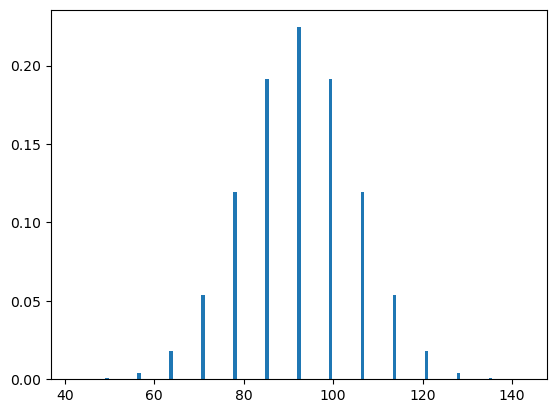

In [58]:
maturities = amd_calls.index.unique()
T0 = maturities[1]
C0 = amd_calls.loc[T0]
C0 = C0.reset_index(drop=True)
T1 = maturities[2]
C1 = amd_calls.loc[T1]
C1 = C1.reset_index(drop=True)
K = np.array(C1['Strike'])
ask = np.array(C1['Ask'])
bid = np.array(C1['Bid'])
mid = np.array(C1['Mid'])

a, b, n = S0-50, S0+50, 15 # Take odd n, such that X1[(n-1)/2] = S0
K1, K2 = a, b
X1 = np.linspace(a,b,n) # Discrete grid

t0 = date(2023, 4, 8)
t1 = maturities[0].to_pydatetime().date()
delta = t1 - t0
delta = delta.days
deltat = delta/252
P1_ = lambda s1: norm.pdf(s1, S0, calculate_sigma(C0,6/252,[S0],[1])*np.sqrt(6/252)) # Marginal distribution of S at t1
P1_disc = lambda x: P1_(x)/sum(P1_(X1))
xx = np.linspace(0,200,1000)
P1_disc_ = np.vectorize(P1_disc)
plt.bar(X1,P1_disc(X1))



u_list, h_list = np.zeros(n), np.zeros(n)
V0 = np.zeros(K.size)
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)

# Test for S at t0
sigma = calculate_sigma(C0,6/252,[S0],[1.])
print(sigma) # Gives same value (82.267) -> OK

# Test for S at t1
#sigma0, beta = calculate_sigma0_beta(C1,7/365,X1,P1_disc(X1))
#print(sigma0)
#print(beta)
#print(sigma0*X1**beta)


# 
sigma = calculate_sigma(C1,6/252,X1,P1_disc(X1))
sigma_sqrtdt = sigma*np.sqrt(6/252)
print(m0(100,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1)))

In [59]:
def I_u_integrand(s2,theta,V,s1,K,sigma_sqrtdt,P_disc_s1):
    return np.exp(-np.sum(V*np.maximum(s2-K,0))-theta*(s2-s1))*m0(s2,s1,K,sigma_sqrtdt,P_disc_s1)

def I_u(theta,V,s1,K,sigma_sqrtdt,P_disc_s1,K1,K2):
    return ntegrate.quad(I_u_integrand,K1,K2,args=(theta,V,s1,K,sigma_sqrtdt,P_disc_s1))[0]


def I_u_(theta,V,s1,K,sigma_sqrtdt,P_disc_s1,K1,K2): 
    #assert(K1 <= K[0] and K2 >= K[-1])
    totI = 0

    for i in range(-1,K.size): 
        alpha = -sum(V[:i+1]) - theta
        gamma = sum(V[:i+1]*K[:i+1]) + (theta*s1)
        expgamma = np.exp(gamma)

        if (i == -1): 
            newPiece = expgamma * I1(alpha,sigma_sqrtdt,s1,K1,K[0])
        elif (i >= 0 and i < K.size-1):
            newPiece = expgamma * I1(alpha,sigma_sqrtdt,s1,K[i],K[i+1]) # Piecewise integration
        else:
            newPiece = expgamma * I1(alpha,sigma_sqrtdt,s1,K[-1],K2)
        
        newPiece *= P_disc_s1
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    #print(f'I_u_ = {totI}')
    return totI


def I_u_vec(theta,V,X1,K,sigma_sqrtdt,P_disc_X1,K1,K2): 
    '''
    Calculates I_u for all points on the grid X1
    '''
    #assert(K1 <= K[0] and K2 >= K[-1])
    totI = 0

    for i in range(-1,K.size): 
        alpha = -sum(V[:i+1]) - theta
        gamma = sum(V[:i+1]*K[:i+1]) + (theta*X1)
        expgamma = np.exp(gamma)

        if (i == -1): 
            newPiece = expgamma * I1(alpha,sigma_sqrtdt,X1,K1,K[0])
        elif (i >= 0 and i < K.size-1):
            newPiece = expgamma * I1(alpha,sigma_sqrtdt,X1,K[i],K[i+1]) # Piecewise integration
        else:
            newPiece = expgamma * I1(alpha,sigma_sqrtdt,X1,K[-1],K2)
        
        newPiece *= P_disc_X1
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    return totI 

K = np.array(C1['Strike'])
sigma_sqrtdt = calculate_sigma(C1,6/252,X1,P1_disc(X1))*np.sqrt(6/252) #TODO: investigate why this one takes so long compared to I_h and I_Q
#print(I_u(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),0,K[0]))
#for i in range(0,numK-1):
    #print(I_u(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),K[i],K[i+1]))
#print(I_u(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),K[-1],110))

print("-----------")
#print(I_u_integrand(100,h_list,V0,X1,K,sigma_sqrtdt,P1_disc(X1)))
#print(I_u_(0,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),0,110)) 
#print(I_u(0,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),0,110))
# I attribute the differences on the boundaries due to inaccuracy in the integral aproximation?


# Test for S at t0
#X0 = np.array([S0])
#P0 = lambda s: 1 if s == S0 else 0
P0_disc = 1.
sigma_sqrtdt0 = 82.26724939*np.sqrt(6/252)
print(I_u_(0,V0,S0,np.array(C0['Strike']),sigma_sqrtdt0,P0_disc,0,110))

-----------
0.9183936107350334


In [60]:
def I_h_0_integrand(s2,theta,V,s1,K,sigma_sqrtdt,P_disc_s1):
    return np.exp(-np.sum(V*np.maximum(s2-K,0))-theta*(s2-s1))*m0(s2,s1,K,sigma_sqrtdt,P_disc_s1)*(s2-s1)

def I_h_0(theta,V,s1,K,sigma_sqrtdt,P_disc_s1,K1,K2):
    return integrate.quad(I_h_0_integrand,K1,K2,args=(theta,V,s1,K,sigma_sqrtdt,P_disc_s1))[0]


def I_h_0_(theta,V,s1,K,sigma_sqrtdt,P_disc_s1,K1,K2):
    #print(f'theta = {theta}')
    #assert(K1 <= K[0] and K2 >= K[-1])
    totI = 0
    
    for i in range(-1,K.size): 
        alpha = -sum(V[:i+1]) - theta
        gamma = sum(V[:i+1]*K[:i+1]) + (theta*s1)
        expgamma = np.exp(gamma)
        #print(f'alpha = {alpha}')
        #print(f'sigma = {sigma}')
        
        if (i == -1): 
            newPiece = expgamma * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma_sqrtdt,s1,K1,K[0])
        elif (i >= 0 and i < K.size-1):
            newPiece = expgamma * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma_sqrtdt,s1,K[i],K[i+1]) # Piecewise integration
        else:
            newPiece = expgamma * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma_sqrtdt,s1,K[-1],K2)
        
        newPiece *= P_disc_s1
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    #print (f'i_h_0_ = {totI}')
    return totI 


def I_h_0_vec(theta,V,X1,K,sigma_sqrtdt,P_disc_X1,K1,K2):
    '''
    Calculates I_h_0 for all points on the grid X1
    '''
    #assert(K1 <= K[0] and K2 >= K[-1])
    totI = 0
    
    for i in range(-1,K.size): 
        alpha = -sum(V[:i+1]) - theta
        gamma = sum(V[:i+1]*K[:i+1]) + (theta*X1)
        expgamma = np.exp(gamma)
        #print(f'alpha = {alpha}')
        #print(f'sigma = {sigma}')
        
        if (i == -1): 
            newPiece = expgamma * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma_sqrtdt,X1,K1,K[0])
        elif (i >= 0 and i < K.size-1):
            newPiece = expgamma * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma_sqrtdt,X1,K[i],K[i+1]) # Piecewise integration
        else:
            newPiece = expgamma * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma_sqrtdt,X1,K[-1],K2)
        
        newPiece *= P_disc_X1
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    return totI


#print(I_h_0_(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),0,110)) 
#print(I_h_0(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),0,110))

# Test for S at t0
P_disc_S1 = 1.
print(I_h_0_(0,V0,S0,np.array(C0['Strike']),sigma_sqrtdt0,P_disc_S1,0,110))




#TODO: implement multidimensional or not? -> yes: is Jacobian!
def I_h_0_grad_integrand(s,theta,V,K,s1,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))-theta*(s-S0))*m0(s,s1,delta_t,P1)*(s-s1)*(s-s1)
    
def I_h_0_grad(theta,V,K,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_h_0_grad_integrand,K1,K2,args=(theta,V,K,s1,delta_t,P1))[0]


def I_h_0_hessian_integrand(s,theta,V,K,s1,sigma0,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))-theta*(s-s1))*m0(s,s1,sigma0,delta_t,P1)*(s-s1)*(s-s1)*(s-s1)

def I_h_0_hessian(theta,V,K,s1,K1,K2,sigma0,delta_t,P1):
    return integrate.quad(I_h_0_hessian_integrand,K1,K2,args=(theta,V,K,s1,sigma0,delta_t,P1))[0]




-1.9157279126242164


In [61]:
def I_Q_integrand(s2,h1,V,X1,K,Q,sigma_sqrtdt,P_disc_X1):
    return np.exp(-np.sum(V*np.maximum(s2-K,0))-h1*(s2-X1))*m0(s2,s1,K,sigma_sqrtdt,P_disc_s1)*np.maximum(s2-Q,0)

def I_Q(h1,V,s1,K,Q,sigma_sqrtdt,P_disc_s1,K1,K2):
    return integrate.quad(I_Q_integrand,K1,K2,args=(h1,V,s1,K,Q,sigma_sqrtdt,P_disc_s1))[0]


I_Q_CONST = 1/(2*np.sqrt(2*math.pi))
def I_Q_(h1,V,s1,K,Q,sigma_sqrtdt,P_disc_s1,K1,K2):
    '''
    Q can be a vector!
    '''
    #assert(K1 <= K[0] and K2 >= K[-1])
    totI = 0
    Q = np.array(Q)
    if (Q.shape == ()):
      totI = np.zeros(1)
    else:
      totI = np.zeros(Q.shape)

    for i in range(-1,K.size): 
        alpha = -sum(V[:i+1]) - h1
        gamma = sum(V[:i+1]*K[:i+1]) + (h1*s1)
        expgamma = np.exp(gamma)
        
        if (i == -1): 
            newPiece = expgamma * I_Q_CONST * I3(alpha,sigma_sqrtdt,s1,Q,K[0],Q) * (K[0] >= Q)
        elif (i >= 0 and i < K.size-1):
            newPiece = expgamma * I_Q_CONST * I3(alpha,sigma_sqrtdt,s1,np.maximum(Q,K[i]),K[i+1],Q) * (K[i+1] >= Q)
        else:
            newPiece = expgamma * I_Q_CONST * I3(alpha,sigma_sqrtdt,s1,np.maximum(Q,K[-1]),K2,Q) 
        
        newPiece *= P_disc_s1
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    #print(f'I_Q_ = {totI}')
    return totI 


def I_Q_vec(h_list,V,X1,K,Q,sigma_sqrtdt,P_disc_X1,K1,K2):
    #assert(K1 <= K[0] and K2 >= K[-1])
    '''
    Calculates I_Q for all points on the grid X1, but Q cannot be a vector!
    '''
    totI = 0

    for i in range(-1,K.size): 
        alpha = -sum(V[:i+1]) - h_list
        gamma = sum(V[:i+1]*K[:i+1]) + (h_list*X1)
        
        if (i == -1): 
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma_sqrtdt,X1,Q,K[0],Q) * (K[0] >= Q)
        elif (i >= 0 and i < K.size-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma_sqrtdt,X1,np.maximum(Q,K[i]),K[i+1],Q) * (K[i+1] >= Q)
        else:
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma_sqrtdt,X1,np.maximum(Q,K[-1]),K2,Q) 

        
        newPiece *= P_disc_X1
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    #print(f'I_Q_vec = {totI}')
    return totI 

#K = np.array(C1['Strike'])
#print(I_Q_(h_list,V0,X1,np.array(C1['Strike']),K,sigma_sqrtdt,P1_disc(X1),0,110))
#print(I_Q(h_list,V0,X1,np.array(C1['Strike']),K[0],sigma_sqrtdt,P1_disc(X1),0,110))

# Test for S at t0
print(I_Q_(0,V0,S0,K,K,sigma_sqrtdt0,P_disc_S1,0,110))

[8.34095027 7.666694   7.01780919 6.39555282 5.80107142 5.23538184
 4.69935373 4.19369412 3.71893476 3.27542239 2.86331237 2.48256577
 2.13295016 1.81404383 1.52524357 1.26577562 1.03470949 0.83097423
 0.65337675 0.50062155]


In [135]:
def G1(V,u0,h0,s1,C,omega,sigma_sqrtdt,P_disc_s1,K1,K2):
    K = np.array(C['Strike'])
    Iu = I_u_(h0,V,s1,K,sigma_sqrtdt,P_disc_s1,K1,K2) 
    expectation = Iu*np.exp(-u0)*P_disc_s1
    #print(f'G1 = {u0 + np.sum(V*mid) + np.sum(f1(V,omega,C)) + expectation}')
    return u0 + np.sum(V*mid) + np.sum(f1(V,omega,C)) + expectation

def G1_(V,u_list,h_list,X1,C,omega,sigma_sqrtdt,P_disc_X1,K1,K2):
    K = np.array(C['Strike'])
    Iu = I_u_vec(h_list,V,X1,K,sigma_sqrtdt,P_disc_X1,K1,K2) # Calculate I_u for all points on the grid X1
    expectation = np.sum(Iu*np.exp(-u_list)*P_disc_X1)
    print(f'G1_ = {np.sum(u_list*P_disc_X1) + np.sum(V*mid) + np.sum(f1(V,omega,C)) + expectation}')
    return np.sum(u_list*P_disc_X1) + np.sum(V*mid) + np.sum(f1(V,omega,C)) + expectation


def grad_G1(V,u0,h0,s1,C,omega,sigma_sqrtdt,P_disc_s1,K1,K2):
    """
    Gradient of G_12 with respect to V_K_i
    """
    K = np.array(C['Strike'])
    mid = np.array(C['Mid'])
    gf1 = grad_f1(V,omega,C)

    grad = gf1 + mid - I_Q_(h0,V,s1,K,K,sigma_sqrtdt,P_disc_s1,K1,K2)*np.exp(-u0)*P_disc_s1 # Q = K
    #print(f'Grad = {grad}')
    #print(f'Grad norm = {np.linalg.norm(grad)}')
    #print(f'grad G1 = {grad}')
    return grad

def grad_G1_(V,u_list,h_list,X1,C,omega,sigma_sqrtdt,P_disc_X1,K1,K2):
    """
    Gradient of G_12 with respect to V_K_i
    """
    K = np.array(C['Strike'])
    mid = np.array(C['Mid'])
    grad = np.zeros(K.size)
    gf1 = grad_f1(V,omega,C)
    for i in range(K.size):
        Q = K[i]
        grad[i] = gf1[i] + mid[i] - np.sum(I_Q_vec(h_list,V,X1,K,Q,sigma_sqrtdt,P_disc_X1,K1,K2)*np.exp(-u_list)*P_disc_X1) # Q = K[i] #TODO: can this be sped up by providing Q as a vector?

    print(f'Grad = {grad}')
    #print(f'Grad norm = {np.linalg.norm(grad)}')
    return grad

In [156]:
def grad_G1_comparison(V,u0,h0,s1,C,omega,sigma_sqrtdt,P_disc_s1,K1,K2):
    '''
    Check whether the expression of the gradient is correct, by comparing it to a finite difference approximation
    '''
    grad = grad_G1(V,u0,h0,s1,C,omega,sigma_sqrtdt,P_disc_s1,K1,K2)
    
    grad_FD = np.zeros(K.size)
    eps = 1e-8
    for i in range(K.size):
        D = np.zeros(K.size)
        D[i] = eps
        grad_FD[i] = (G1(V+D,u0,h0,s1,C,omega,sigma_sqrtdt,P_disc_s1,K1,K2)-G1(V,u0,h0,s1,C,omega,sigma_sqrtdt,P_disc_s1,K1,K2))/eps
        
    print(f'Grad = {grad}')
    print(f'Grad_FD = {grad_FD}')

In [137]:
print(G1_(V0,u_list,h_list,X1,C1,omega_K,sigma_sqrtdt,P1_disc(X1),K1,K2))
print(grad_G1_(V0,u_list,h_list,X1,C1,omega_K,sigma_sqrtdt,P1_disc(X1),K1,K2))

G1_ = nan
nan
Grad = [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]


In [138]:
maturities = amd_calls.index.unique()
maturities

DatetimeIndex(['2023-04-06', '2023-04-14', '2023-04-21', '2023-04-28',
               '2023-05-05', '2023-05-12', '2023-05-19', '2023-05-26',
               '2023-06-16', '2023-07-21', '2023-09-15', '2023-10-20',
               '2024-01-19', '2024-06-21', '2025-01-17', '2025-12-19'],
              dtype='datetime64[ns]', name='Expiration Date', freq=None)

In [157]:
#t = 0
T0 = maturities[1]
C0 = amd_calls.loc[T0]
C0 = C0.reset_index(drop=True)

r = 0.01 # TODO: figure out r
K = np.array(C0['Strike'])
ask = np.array(C0['Ask'])
bid = np.array(C0['Bid'])
mid = np.array(C0['Mid'])
S0 = 92.3
K1, K2 = S0-50, S0+50 # Take odd n, such that X1[(n-1)/2] = S0
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)
delta_t = 6/252
P_disc_s1 = 1.
sigma0 = calculate_sigma(C0,delta_t,S0,P_disc_s1)
sigma_sqrtdt0 = sigma0*np.sqrt(delta_t)
#print(sigma0)
#print(G1(np.zeros(K.size),0.,0.,S0,C0,omega_K,sigma_sqrtdt0,P_disc_s1,K1,K2))
grad_G1_comparison(0.1*np.ones(K.size),0.,0.,S0,C0,omega_K,sigma_sqrtdt0,P_disc_s1,K1,K2) # For too high coefficients in V the difference gets larger!

Grad = [8.88208849 8.03325925 7.13733767 6.27195028 5.44145293 4.62488909
 3.85145884 3.44805818 2.96335042 2.43395733 1.94973514 1.5233723
 1.15817142 0.86495802 0.63006979 0.46017187 0.33019453 0.23509905
 0.17019985 0.13019998]
Grad_FD = [9.94945124 9.10062231 8.20470111 7.33931414 6.50881746 5.6918859
 4.451      3.751      3.101      2.4902     1.9704     1.5302
 1.1602     0.8655     0.6302     0.4602     0.3302     0.2351
 0.1702     0.1302    ]


In [140]:
# I tried to recreate the results of the first maturity here
#%%prun
u0, h0, V = 0., 0., np.array([0.]*K.size)
V_prev = np.array([1.] *K.size)

while np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev) > 1e-5:
    V_prev = V
    h0 = optimize.root_scalar(I_h_0_,args=(V,S0,K,sigma_sqrtdt0,1.,K1,K2) ,bracket = [-0.1,0.1],x0=0.00005, fprime = I_h_0_grad, fprime2 = I_h_0_hessian).root
    print(f' h0 = {h0}')
    u0 = -np.log(1/I_u_(h0,V,S0,K,sigma_sqrtdt0,1.,K1,K2))
    print(f' u0 = {u0}')



    #V = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,sigma0,t1), method='BFGS', jac= grad_G1, hess=Hess_G1, hessp=None, bounds=None, constraints=(), tol=1e-2, callback=None, options=None).x
    V = optimize.minimize(fun= G1, x0=V, args=(u0,h0,S0,C0,omega_K,sigma_sqrtdt0,1.,K1,K2), method='Newton-CG', jac= grad_G1, hess=None, hessp=None, bounds=None, constraints=(), tol=1e-5, callback=None, options=None).x
    print(f'V = {V}')
    
    print(f'normdiff = {np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev)}')
    print("----------")


 h0 = 1.3877787807814457e-17
 u0 = -8.188192250058795e-05
V = [ 0.27157407 -0.61658606  0.11204987  0.18934247 -0.16768566  0.05986023
  0.31161793 -0.16044931 -0.35664784  0.27795269  0.179689   -0.02898813
  0.01963793 -0.03896134  0.13886646 -0.02398934  0.05165848  0.14675536
  0.06402373 -0.21584893]
normdiff = inf
----------
 h0 = -0.039932603173159976
 u0 = 0.12753620920082773


/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_43538/2780409993.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  print(f'normdiff = {np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev)}')
/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_43538/2780409993.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  while np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev) > 1e-5:


V = [ 0.25812325 -0.62530193  0.10840983  0.18956566 -0.16464427  0.06536867
  0.31906946 -0.15241467 -0.34842727  0.28670803  0.18779731 -0.02164671
  0.02640497 -0.03317181  0.14385095 -0.02024641  0.05467615  0.14933488
  0.06616948 -0.21490805]
normdiff = 0.02899328222335301
----------
 h0 = -0.0512759603748152
 u0 = 0.13960017065135852
V = [ 0.25722751 -0.62574378  0.10845199  0.18993853 -0.16407361  0.06609015
  0.31987994 -0.15166875 -0.34778009  0.28731645  0.18825589 -0.02131842
  0.02665652 -0.03301894  0.14394481 -0.02025091  0.05463923  0.14929873
  0.06613035 -0.21498839]
normdiff = 0.002100435166375893
----------
 h0 = -0.053039250529864475
 u0 = 0.12932749193376245
V = [ 0.25735104 -0.62558253  0.10865466  0.19016356 -0.16384264  0.06632143
  0.32010426 -0.15146981 -0.34761     0.28746613  0.18837282 -0.02123003
  0.02672485 -0.03297165  0.14397767 -0.02023581  0.05464612  0.14930265
  0.06613171 -0.21499375]
normdiff = 0.0006408508420456087
----------
 h0 = -0.054308167

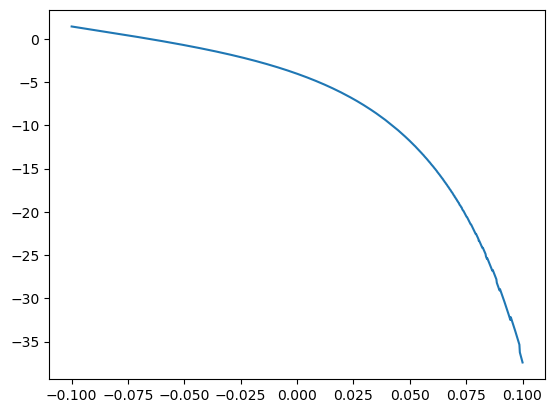

In [141]:
hh = np.linspace(-0.1,0.1,1000)
I_h = lambda h: I_h_0_(h,V,S0,K,sigma_sqrtdt0,P_disc_s1,K1,K2)
plt.plot(hh,I_h(hh))

In [142]:
c = I_Q_(h0,V,S0,K,K,sigma_sqrtdt0,1.,K1,K2)*np.exp(-u0)
print(c)

[9.7240296  8.8078424  7.90379924 7.01774441 6.15762097 5.33056921
 4.54797881 3.8197697  3.14537916 2.52967243 1.99158802 1.53930343
 1.16694345 0.86709606 0.63223773 0.45518196 0.32517487 0.23262366
 0.16829909 0.12285133]


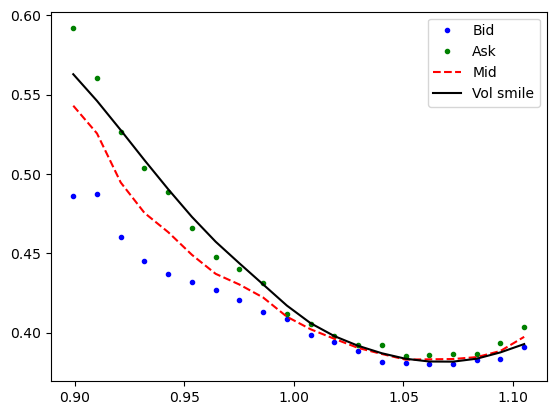

In [143]:
# Plot data
fig, ax = plt.subplots()
T_ = 6/252
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(bid,K,T_,r,S0)), 'b.', label='Bid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(ask,K,T_,r,S0)), 'g.', label='Ask')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(mid,K,T_,r,S0)), 'r--', label='Mid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(c,K,T_,r,S0)), 'k', label='Vol smile')
plt.legend()
plt.show()

[0.00510709 0.00542985 0.00576406 0.00610935 0.00646529 0.00683137
 0.00720698 0.00759145 0.00798404 0.00838391 0.00879017 0.00920182
 0.00961782 0.01003704 0.01045829 0.01088034 0.01130186 0.01172152
 0.01213791 0.01254961 0.01295516 0.01335308 0.01374189 0.0141201
 0.01448622 0.0148388  0.0151764  0.01549761 0.01580109 0.01608553
 0.01634971 0.01659247 0.01681273 0.0170095  0.0171819  0.01732914
 0.01745055 0.01754556 0.01761375 0.01765478 0.01766848 0.01765478
 0.01761375 0.01754556 0.01745055 0.01732914 0.0171819  0.0170095
 0.01681273 0.01659247 0.01634971 0.01608553 0.01580109 0.01549761
 0.0151764  0.0148388  0.01448622 0.0141201  0.01374189 0.01335308
 0.01295516 0.01254961 0.01213791 0.01172152 0.01130186 0.01088034
 0.01045829 0.01003704 0.00961782 0.00920182 0.00879017 0.00838391
 0.00798404 0.00759145 0.00720698 0.00683137 0.00646529 0.00610935
 0.00576406 0.00542985 0.00510709]
[ 2.49536617  2.6216602   2.7534155   2.89082856  3.0341015   3.18344226
  3.33906464  3.5011885

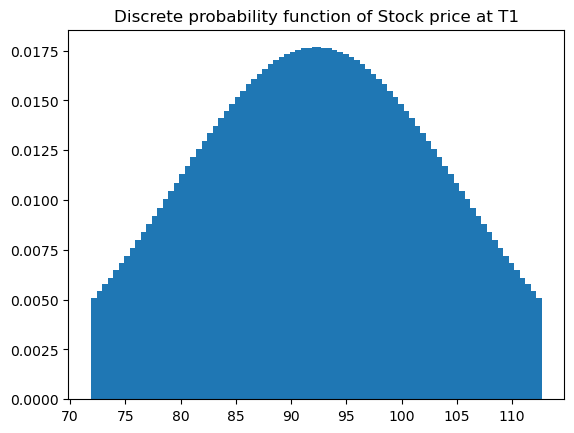

In [144]:
#t = T1
T1 = maturities[2]
C1 = amd_calls.loc[T1]
C1 = C1.reset_index(drop=True)

r = 0.01 # TODO: figure out r
K = np.array(C1['Strike'])
ask = np.array(C1['Ask'])
bid = np.array(C1['Bid'])
mid = np.array(C1['Mid'])
S0 = 92.3
a, b, n = S0-20, S0+20, 81 # Take odd n, such that X1[(n-1)/2] = S0
K1, K2 = a-10, b+10
X1 = np.linspace(a,b,n) # Discrete grid
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)
delta_t = 7/365

sigma_prev = sigma0 
P1 = lambda s1: norm.pdf(s1, S0, sigma_sqrtdt0) # Marginal distribution of S at t1, sigma of previous marginal is used!!!
P1_disc = lambda x: P1(x)/sum(P1(X1))
P1_disc_ = np.vectorize(P1_disc)
plt.bar(X1,P1_disc_(X1))
plt.title('Discrete probability function of Stock price at T1')
P_disc_X1 = P1_disc(X1)
print(P_disc_X1)

sigma = calculate_sigma(C1,delta_t,X1,P_disc_X1)
sigma_sqrtdt = sigma*np.sqrt(delta_t)
print(sigma_sqrtdt)

In [154]:
# Now for the maturity T1
u0, h0, V = 0., 0., np.array([0.]*K.size)
h0_prev = 0.0005
V_prev = np.array([1.] *K.size)
u_list, h_list = np.zeros(n), np.zeros(n)

while np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev) > 1e-5:
    V_prev = V
    for i in range(n):
        print(f'i = {i}')
        s1 = X1[i]
        P_disc_s1 = P_disc_X1[i]
        sigma_sqrtdt_i = sigma_sqrtdt[i]
        h0 = optimize.root_scalar(I_h_0_,args=(V,s1,K,sigma_sqrtdt_i,P_disc_s1,K1,K2) ,bracket = [h0_prev-0.01,h0_prev+0.01],x0=h0_prev, fprime = I_h_0_grad, fprime2 = I_h_0_hessian).root
        print(f' h0 = {h0}')
        u0 = -np.log(1/I_u_(h0,V,s1,K,sigma_sqrtdt_i,P_disc_S1,K1,K2))
        print(f' u0 = {u0}')
        h0_prev = h0
        
        u_list[i] = u0
        h_list[i] = h0



    #V = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,sigma0,t1), method='BFGS', jac= grad_G1, hess=Hess_G1, hessp=None, bounds=None, constraints=(), tol=1e-2, callback=None, options=None).x
    V = optimize.minimize(fun= G1_, x0=V, args=(u_list,h_list,X1,C0,omega_K,sigma_sqrtdt,P_disc_X1,K1,K2), method='Newton-CG', jac= grad_G1_, hess=None, hessp=None, bounds=None, constraints=(), tol=1e-5, callback=None, options=None).x
    print(f'V = {V}')
    
    print(f'normdiff = {np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev)}')
    print("----------")



i = 0
 h0 = -9.773460374530181e-19
 u0 = -4.440892098500625e-16
i = 1
 h0 = 3.469446951953614e-18
 u0 = -2.2204460492503128e-16
i = 2
 h0 = -1.734723475976807e-18
 u0 = 2.220446049250313e-16
i = 3
 h0 = 0.0
 u0 = 2.220446049250313e-16
i = 4
 h0 = 0.0
 u0 = -0.0
i = 5
 h0 = 1.734723475976807e-18
 u0 = 4.440892098500627e-16
i = 6
 h0 = -1.734723475976807e-18
 u0 = 4.440892098500627e-16
i = 7
 h0 = 0.0
 u0 = -2.2204460492503128e-16
i = 8
 h0 = -1.734723475976807e-18
 u0 = 2.220446049250313e-16
i = 9
 h0 = -3.469446951953614e-18
 u0 = -2.2204460492503128e-16
i = 10
 h0 = 5.204170427930421e-18
 u0 = -2.2204460492503128e-16
i = 11
 h0 = 3.8163916471489756e-17
 u0 = -6.661338147750937e-16
i = 12
 h0 = 3.677613769070831e-16
 u0 = 2.220446049250313e-16
i = 13
 h0 = 2.699229728619912e-15
 u0 = -1.332267629550187e-15
i = 14
 h0 = 1.7551932129933334e-14
 u0 = -1.0658141036401446e-14
i = 15
 h0 = 1.0084121038200777e-13
 u0 = -6.328271240363192e-14
i = 16
 h0 = 5.164445260330552e-13
 u0 = -3.4772185

ValueError: Jacobian is required for Newton-CG method

/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_43538/944812879.py:7: RuntimeWarning: overflow encountered in exp
  return sigma*np.exp(alpha*s1) * ( 2*(np.exp(A*alpha*sigma-A*A/2) - np.exp(B*alpha*sigma-B*B/2)) + np.sqrt(2*np.pi)*alpha*sigma*np.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2))) )
/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_43538/944812879.py:7: RuntimeWarning: invalid value encountered in multiply
  return sigma*np.exp(alpha*s1) * ( 2*(np.exp(A*alpha*sigma-A*A/2) - np.exp(B*alpha*sigma-B*B/2)) + np.sqrt(2*np.pi)*alpha*sigma*np.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2))) )
/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_43538/2718719290.py:16: RuntimeWarning: overflow encountered in exp
  expgamma = np.exp(gamma)
/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_43538/944812879.py:7: Runtime

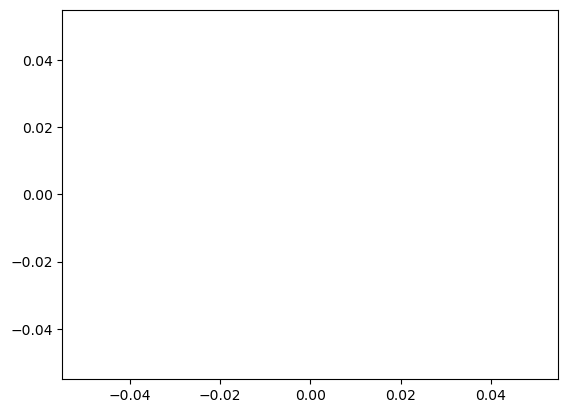

In [146]:
hh = np.linspace(-0.15,-0.05,1000)
i = 74
I_h = lambda h: I_h_0_(h,V,X1[i],K,sigma_sqrtdt[i],P_disc_X1[i],K1-10,K2+10) # Doesn't seem to have a zero?
plt.plot(hh,I_h(hh))

In [147]:
I_h_0_(2,V,X1[1],K,sigma_sqrtdt[0],P_disc_X1[0],K1,K2)

/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_43538/944812879.py:7: RuntimeWarning: overflow encountered in exp
  return sigma*np.exp(alpha*s1) * ( 2*(np.exp(A*alpha*sigma-A*A/2) - np.exp(B*alpha*sigma-B*B/2)) + np.sqrt(2*np.pi)*alpha*sigma*np.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2))) )
/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_43538/944812879.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return sigma*np.exp(alpha*s1) * ( 2*(np.exp(A*alpha*sigma-A*A/2) - np.exp(B*alpha*sigma-B*B/2)) + np.sqrt(2*np.pi)*alpha*sigma*np.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2))) )
/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_43538/2718719290.py:16: RuntimeWarning: overflow encountered in exp
  expgamma = np.exp(gamma)


nan